In [1]:
import numpy as np
import tensorflow as tf
import random
from tensorflow import keras
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer 
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, UpSampling2D
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageChops, ImageOps
from sklearn.model_selection import train_test_split

In [2]:
img_full_size_x = 128
img_full_size_y = 128
img_noisy_size_x = 32
img_noisy_size_y = 32

In [3]:
def get_img(path):
    test_img = Image.open(path)
    test_img = test_img.resize((img_full_size_x, img_full_size_y))
    test_img_noisy = test_img.resize((img_noisy_size_x, img_noisy_size_y))
    test_x = np.array(test_img, np.float32) / 255
    noisy_test_x = np.array(test_img_noisy, np.float32) / 255
    return test_x, noisy_test_x

In [4]:
path = 'D:/Лабы 3 курс/МНСиРО/Lab3/lfw_funneled'
folder_list = os.listdir(path)

In [5]:
# считывание данных
x_full = []
x_noisy = []
for folder in folder_list:
    i = 0
    file_list = os.listdir(path + '/' + folder)
    for file in file_list:
        img_full, img_noisy = get_img(path + '/' + folder + '/' + file)
        x_full.append(img_full)
        x_noisy.append(img_noisy)
        if len(x_full) % 100 == 0:
            print("считано " + str(len(x_full)) + " изображений")
    if len(x_full) >= 500:
        break

x_full = np.array(x_full)
x_noisy = np.array(x_noisy)
print(x_full[0])

считано 100 изображений
считано 200 изображений
считано 300 изображений
считано 400 изображений
считано 500 изображений
[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.03137255 0.03137255 0.02352941]
  [0.02745098 0.02745098 0.01960784]
  [0.00784314 0.00784314 0.00784314]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.03137255 0.03137255 0.02352941]
  [0.03137255 0.03137255 0.02745098]
  [0.01568628 0.01568628 0.01568628]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.02352941 0.02352941 0.02352941]
  [0.02352941 0.02352941 0.02745098]
  [0.01176471 0.01176471 0.01176471]]

 ...

 [[0.         0.         0.        ]
  [0.24313726 0.25490198 0.28627452]
  [0.5254902  0.5647059  0.654902  ]
  ...
  [0.54509807 0.5803922  0.6431373 ]
  [0.39607844 0.4392157  0.498

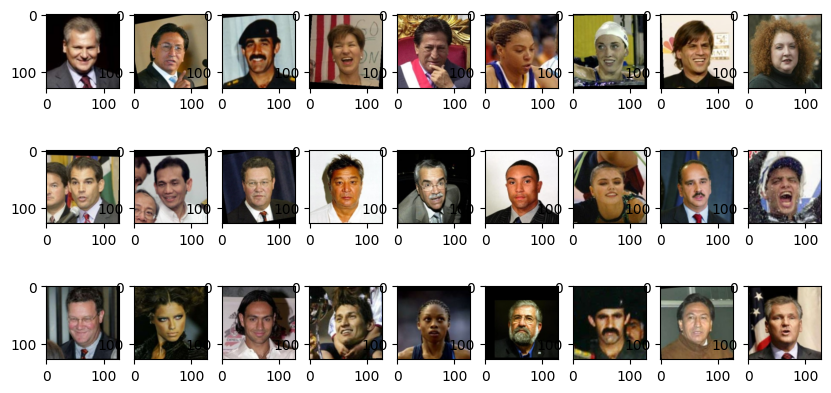

In [6]:
plt.figure(figsize=(10,5))
for i in range(27):
    plt.subplot(3,9,i + 1)
    plt.imshow(x_full[random.randint(0, len(x_full)-1)])

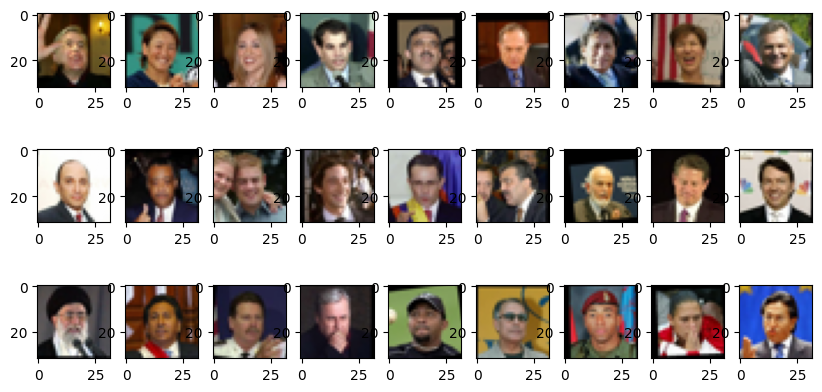

In [7]:
plt.figure(figsize=(10,5))
for i in range(27):
    plt.subplot(3,9,i + 1)
    plt.imshow(x_noisy[random.randint(0, len(x_noisy)-1)])

In [8]:
x_train, x_test = train_test_split(x_noisy, test_size=0.1, random_state=42)
y_train, y_test = train_test_split(x_full, test_size=0.1, random_state=42)

In [9]:
print(x_full.shape)
print(x_test.shape)

(500, 128, 128, 3)
(50, 32, 32, 3)


In [10]:
def build_autoencoder(img_shape, activation):
    input_layer = Input(shape=img_shape)
    #encoder
    encoded_layer1 = Conv2D(32, (3, 3), activation=activation, padding='same')(input_layer)
    encoded_layer1 = MaxPool2D((2, 2), padding='same')(encoded_layer1)
    encoded = Conv2D(16, (3, 3), activation=activation, padding='same')(encoded_layer1)
    decoded_layer1 = Conv2D(32, (3, 3), activation=activation, padding='same')(encoded)
    decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)    
    decoded_layer2 = Conv2D(64, (3, 3), activation=activation, padding='same')(decoded_layer1)
    decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
    decoded_layer3 = Conv2D(128, (3, 3), activation=activation, padding='same')(decoded_layer2)
    decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
    output_layer = Conv2D(3, (3, 3), padding='same', activation=activation)(decoded_layer3)
    return input_layer, output_layer

In [11]:
IMG_SHAPE = x_noisy.shape[1:]
inp_l, out_l = build_autoencoder(IMG_SHAPE, None)
inp = Input(IMG_SHAPE)
autoencoder = Model(inp_l, out_l)
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='mse')
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        4624      
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 32)       0         
 )                                                           

In [12]:
history = autoencoder.fit(x=x_train, y=y_train, batch_size=128, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
4/4 [==============================] - 34s 8s/step - loss: 0.1662 - val_loss: 0.0771
Epoch 2/20
4/4 [==============================] - 33s 8s/step - loss: 0.0774 - val_loss: 0.0469
Epoch 3/20
4/4 [==============================] - 35s 9s/step - loss: 0.0407 - val_loss: 0.0313
Epoch 4/20
4/4 [==============================] - 33s 8s/step - loss: 0.0353 - val_loss: 0.0302
Epoch 5/20
4/4 [==============================] - 34s 8s/step - loss: 0.0314 - val_loss: 0.0261
Epoch 6/20
4/4 [==============================] - 33s 8s/step - loss: 0.0277 - val_loss: 0.0263
Epoch 7/20
4/4 [==============================] - 34s 8s/step - loss: 0.0270 - val_loss: 0.0241
Epoch 8/20
4/4 [==============================] - 33s 8s/step - loss: 0.0246 - val_loss: 0.0219
Epoch 9/20
4/4 [==============================] - 35s 8s/step - loss: 0.0231 - val_loss: 0.0210
Epoch 10/20
4/4 [==============================] - 34s 8s/step - loss: 0.0222 - val_loss: 0.0201
Epoch 11/20
4/4 [======================

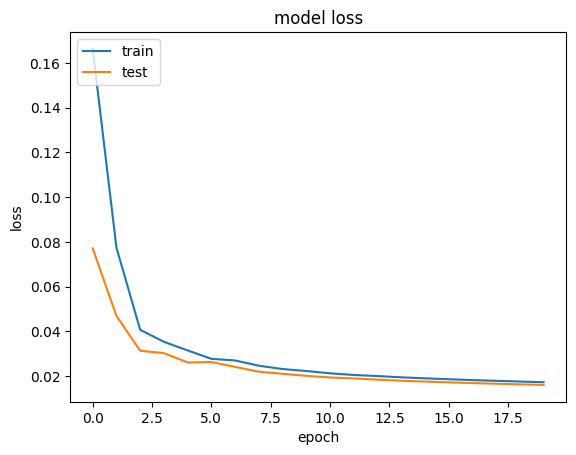

In [13]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


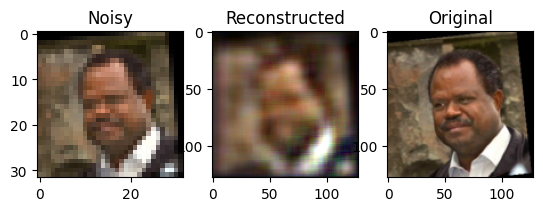

1/1 [==============================] - 0s 35ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


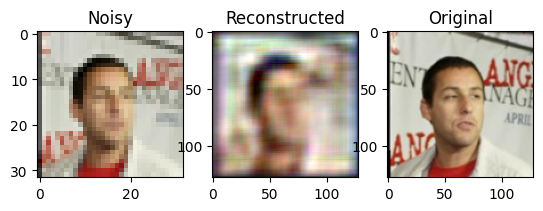

1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


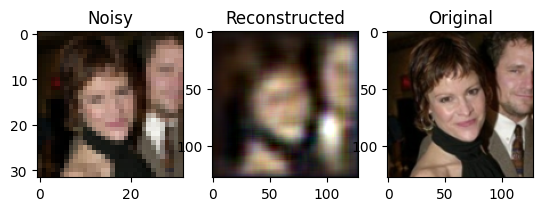

1/1 [==============================] - 0s 122ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


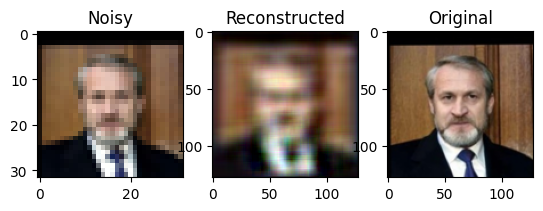

1/1 [==============================] - 0s 35ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


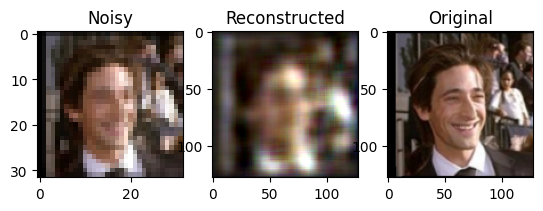

In [14]:
def visualize(img_noisy, img, autoencoder):
    reconstructed = autoencoder.predict(img_noisy[None])[0]
    plt.subplot(1,3,1) 
    plt.title("Noisy") 
    plt.imshow(img_noisy)
    plt.subplot(1,3,2)
    plt.title("Reconstructed")
    plt.imshow(reconstructed)
    plt.subplot(1,3,3)
    plt.title("Original")
    plt.imshow(img)
    plt.show()
    
for i in range(5): 
    img_noisy = x_test[i]
    img = y_test[i]
    visualize(img_noisy, img, autoencoder)